# TUTORIAL: Bias-aware data assimilation on the Rijke tube


In [6]:
from utils import set_working_directories
data_folder, results_folder = set_working_directories('rijke/')[:2]


In [7]:
from models_physical import Rijke
from create import create_truth
from plot_results import plot_truth

truth = create_truth(model=Rijke,
                     manual_bias='linear',
                     t_start=.2, 
                     t_stop=.6,
                     dt_obs=20)
plot_truth(**truth, f_max=1200, window=0.02, fig_width=20)


KeyboardInterrupt: 

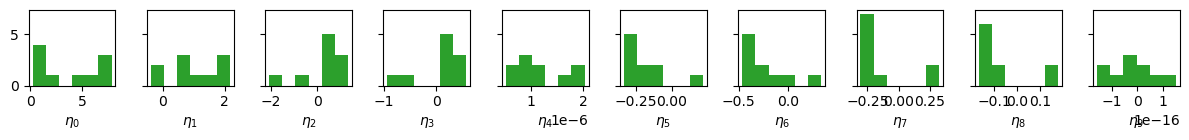

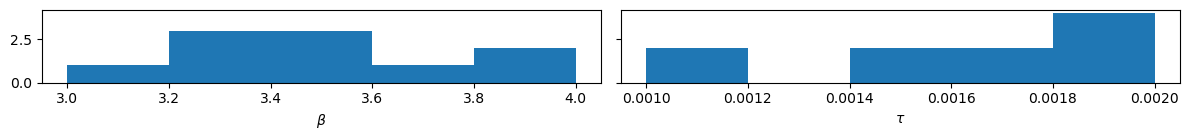

In [ ]:
from create import create_ensemble
from plot_results import plot_ensemble


ensemble = create_ensemble(model=Rijke,
                           filter='rBA_EnKF',  # 'rBA_EnKF' 'EnKF' 'EnSRKF'
                           est_a=['beta', 'tau'],
                           std_a=dict(beta=[3., 4.], 
                                      tau=[1e-3, 2e-3]),
                           std_psi=0.25,
                           reject_inflation=1.005,
                           m=10
                           )
plot_ensemble(ensemble, max_modes=10)

Create bias model:  /Users/anovoama/real-time-bias-aware-DA/real_public/results/tutorials/rijke/ESN_case_rijke_linear2
Rerun training data
Not correlation_based_training


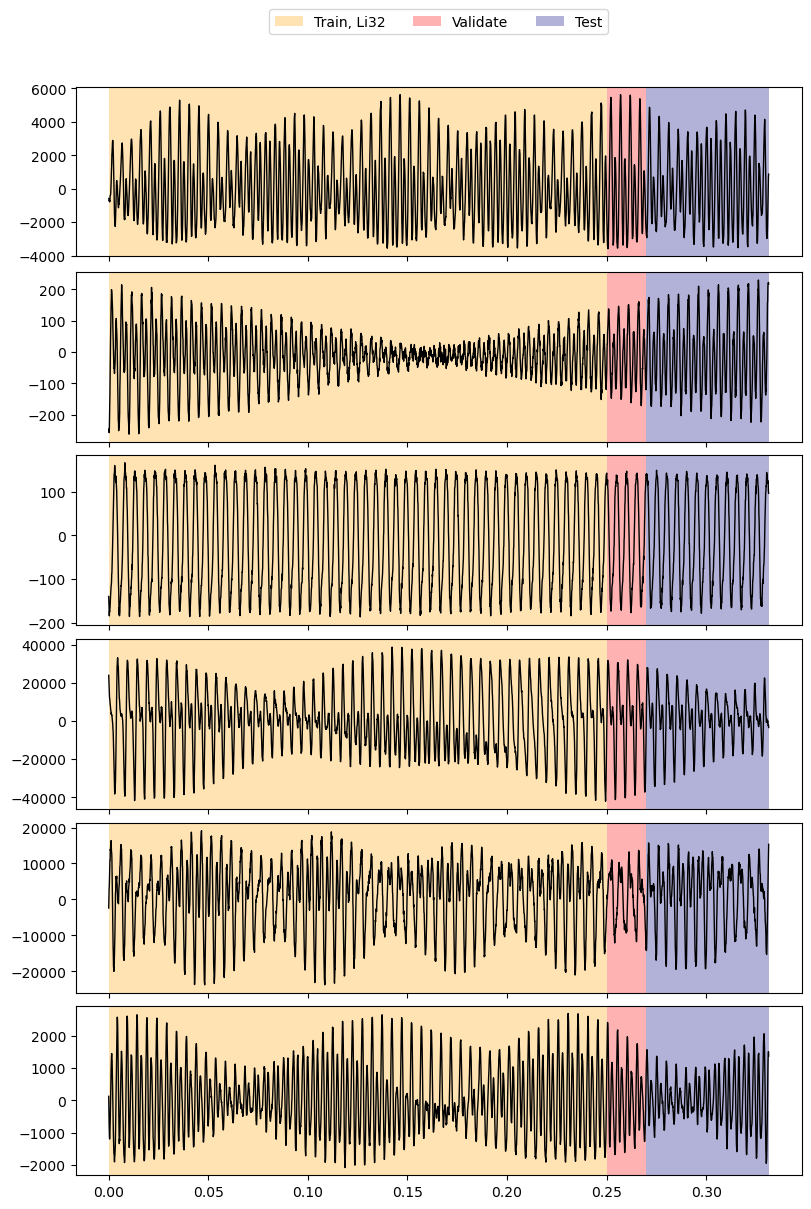


 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 1.000e-05	 1.000e-16	 -7.9459
2	 2.000e-01	 1.000e-04	 1.000e-16	 -7.8391
3	 2.000e-01	 1.000e-03	 1.000e-16	 -7.6709
4	 2.000e-01	 1.000e-02	 1.000e-16	 -7.9387
5	 4.667e-01	 1.000e-05	 1.000e-16	 -7.9355


KeyboardInterrupt: 

In [ ]:
from bias import ESN
from create import create_bias_model
import numpy as np

bias_params = dict(bias_model=ESN,  # ESN / NoBias
                   N_units=100,
                   upsample=2,
                   # Training data generation  options
                   augment_data=True,
                   biased_observations=False,
                   correlation_based_training=False,
                   L=20,
                   est_a=ensemble.est_a,
                   std_a=0.3,
                   # Training, val and wash times
                   t_val=0.02,
                   t_train=0.25,
                   t_test=0.06,
                   N_wash=15, 
                    # Hyperparameter search ranges
                   rho_range=[0.2, 1.0],
                   tikh_range=np.array([1e-16]),
                   sigma_in_range=[np.log10(1e-5), np.log10(1e-2)],
                   )


bias, wash_obs, wash_t = create_bias_model(ensemble, training_dataset=truth, bias_params=bias_params, 
                                           folder=results_folder, 
                                           bias_filename=f"ESN_case_rijke_{truth['name_bias']}2") 
                                           # Note: if the filename and folder are given, the bias case is saved.


In [ ]:
from data_assimilation import dataAssimilation


filter_ens = ensemble.copy()
filter_ens.bias = bias.copy()
filter_ens.inflation = 1.

filter_ens.regularization_factor = 1.

filter_ens = dataAssimilation(filter_ens, 
                              y_obs=truth['y_obs'], t_obs=truth['t_obs'], std_obs=0.1, 
                              wash_obs=wash_obs, wash_t=wash_t, Nt_extra=int(10*ensemble.t_CR // ensemble.dt))


 ------------------ Rijke Model Parameters ------------------ 
	 C1 = 0.050000
	 C2 = 0.010000
	 L = 1.000000
	 Nc = 50
	 Nm = 10
	 beta = 4.000000
	 kappa = 100000.000000
	 law = sqrt
	 tau = 0.001500
	 xf = 0.200000

 ---------------- Bias_ESN bias model input_parameters --------------- 
	 L = 20
	 N_ens = 1
	 N_units = 100
	 N_wash = 15
	 bayesian_update = False
	 connect = 3
	 observed_idx = [0 1 2 3 4 5]
	 perform_test = True
	 rho = 0.737759
	 sigma_in = 1.96273e-05
	 t_train = 0.25
	 t_val = 0.02
	 tikh = 1e-16
	 update_reservoir = False
	 upsample = 2

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF 
 	 Bias = Bias_ESN 
 	 m = 10 
 	 Time steps between analysis = 20 
 	 Inferred params = ['beta', 'tau'] 
 	 Inflation = 1.0 
 	 Reject Inflation = 1.005 
 	 Ensemble std(psi0) = 0.25
 	 Ensemble std(alpha0) = {'beta': [3.0, 4.0], 'tau': [0.001, 0.002]}
 	 Number of analysis steps = 200, t0=0.2, t1=0.598
	 Bias penalisation factor k = 1.0



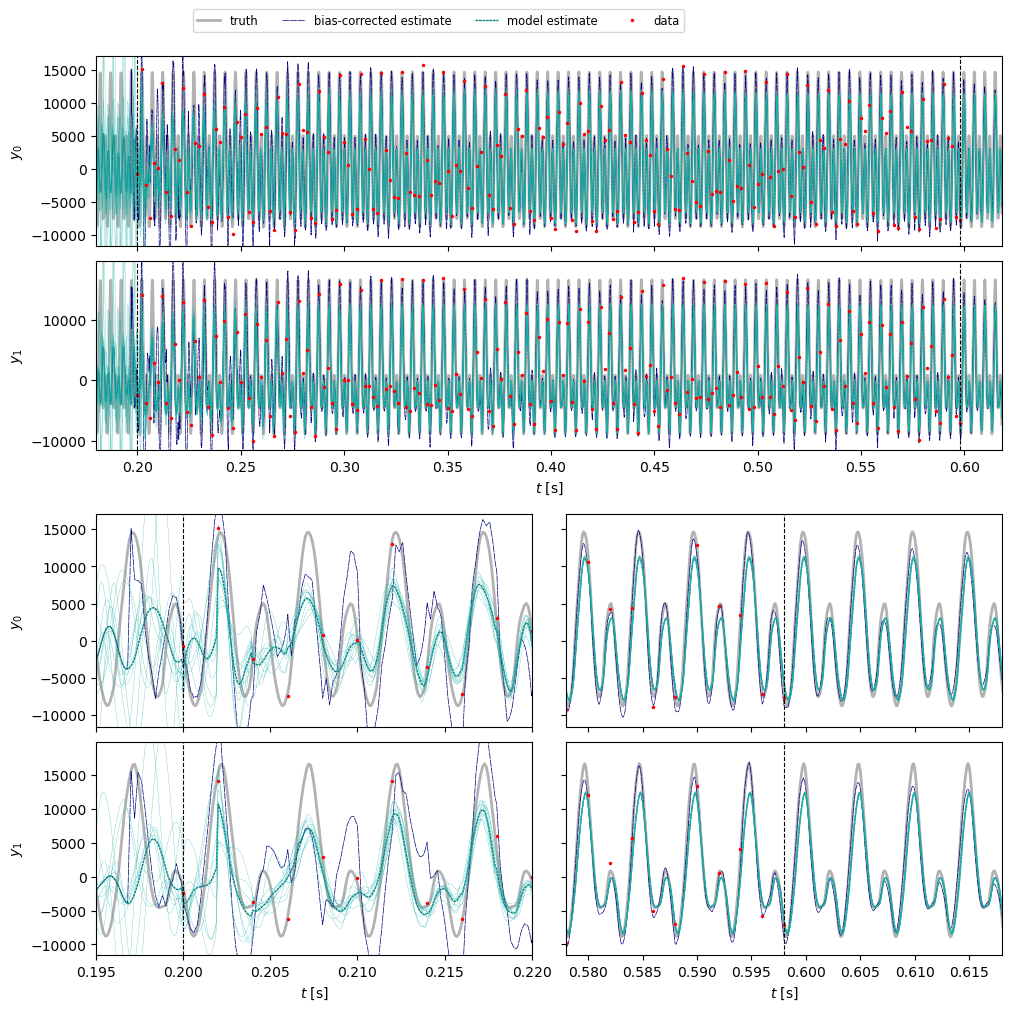

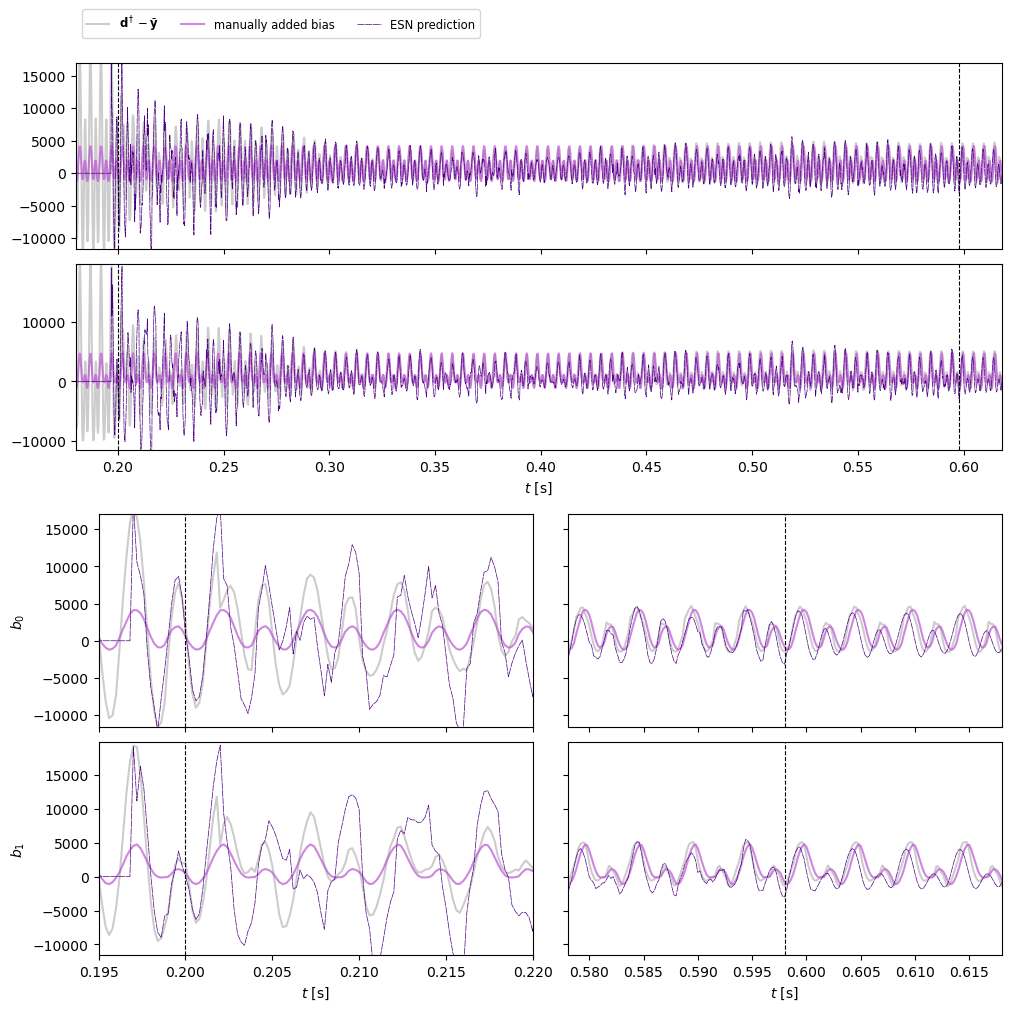

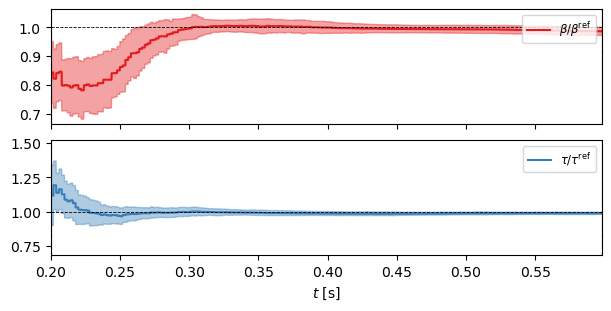

In [ ]:
from plot_results import plot_parameters, plot_timeseries

plot_timeseries(filter_ens, truth, plot_ensemble_members=True, plot_bias=True, dims=[0,1])
plot_parameters(filter_ens, truth, reference_p=filter_ens.get_default_params)

